In [251]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import precision_score
import os
import gzip
import random
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline

In [252]:
#Returns a string of length bytes long
def dataloader(filepath, length):
    f = gzip.GzipFile(fileobj=open(filepath, 'rb'))
    data = f.read(length)
    return data.decode("utf-8")

In [253]:
#Splits the data into num_chunks
def chunk(in_string,num_chunks):
    chunk_size = len(in_string)//num_chunks
    if len(in_string) % num_chunks: chunk_size += 1
    iterator = iter(in_string)
    for _ in range(num_chunks):
        accumulator = list()
        for _ in range(chunk_size):
            try: accumulator.append(next(iterator))
            except StopIteration: break
        yield ''.join(accumulator)

In [295]:
def FeatureImportance(model, features, importance):
    for im in importance:
        feature_important = model.get_score(importance_type = im)
        keys = list(feature_important.keys())
        feature_chars = []
        keylist = []
        for key in keys:
            keylist.append(int(key.replace('f','')))
        for i in keylist:
            feature_chars.append(features[i])
        values = list(feature_important.values())
        fdata = pd.DataFrame(data=values, index=feature_chars, columns=["score"]).sort_values(by = "score", ascending=False)
        fdata.plot(kind='barh', title = im)    
        
    

In [302]:
def FileClassifier(Dataset, ngram_range, max_features, param, num_round):
    
    X = Dataset.iloc[:,0].values
    y = Dataset.iloc[:,1].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
    char_vectorizer = TfidfVectorizer(analyzer = 'char',
        ngram_range = ngram_range, max_features = max_features)
    char_vectorizer.fit(X)
    #print(type(X_train))
    train_chars = char_vectorizer.transform(X_train)
    test_chars = char_vectorizer.transform(X_test)
    #print(type(test_chars.todense()))
    #xgbmodel = make_pipeline()
    
    
    dtrain = xgb.DMatrix(train_chars, label = y_train)
    #print(dtrain.columns)
    dtest = xgb.DMatrix(test_chars, label = y_test)
    
    model = xgb.train(param, dtrain, num_round)
    #print(model)
    #model = xgb.XGBClassifier(param)
    #model.fit(train_chars, y_train)
    #xgb.plot_importance(model)
    #pyplot.show()
    
    FeatureImportance(model, char_vectorizer.get_feature_names(), ['weight','cover','gain'])
    
    preds = model.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    print(precision_score(y_test, best_preds, average='macro'))
    print(np.asarray(y_test).reshape(1,-1).squeeze())
    print(best_preds)
    
    
    return(model)

In [275]:
data = dataloader('/Users/bf/Desktop/BNL2020/BioClassifierFiles/GCA_902387845.1_UHGG_MGYG-HGUT-02512_genomic.fna.gz', 40000)
data1 = dataloader('/Users/bf/Desktop/BNL2020/BioClassifierFiles/SRR9259133.fastq.gz', 40000)
data2 = dataloader('/Users/bf/Desktop/BNL2020/BioClassifierFiles/GCA_002097535.1_ASM209753v1_genomic.gff.gz', 40000)
data3 = dataloader('/Users/bf/Desktop/BNL2020/BioClassifierFiles/GCA_003568845.1_ASM356884v1_genomic.gbff.gz', 40000)

In [276]:
#Split the 40000 byte data into 1000 byte pieces
FastDat = list(chunk(data,40)) + list(chunk(data1, 40)) + list(chunk(data2, 40)) + list(chunk(data3, 40))
data = {'FastDat': FastDat,
        'Type': np.concatenate((np.repeat(0,40),np.repeat(1,40), np.repeat(2,40), np.repeat(3,40)))
    }
df = pd.DataFrame(data, columns = ['FastDat', 'Type'])


In [293]:
param = {
    'max_depth': 4,  # the maximum depth of each tree
    'eta': 0.2,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 4}  # the number of classes that exist in this datset
num_round = 40 
ngram_range = (2,4)
max_features = 10000
Dataset = df
max_len = 20

[09:57:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


1.0
[2 2 3 1 2 0 2 1 2 3 0 2 0 1 0 0 3 3 2 0 1 0 0 0 0 3 2 1 3 2 3 1]
[2 2 3 1 2 0 2 1 2 3 0 2 0 1 0 0 3 3 2 0 1 0 0 0 0 3 2 1 3 2 3 1]


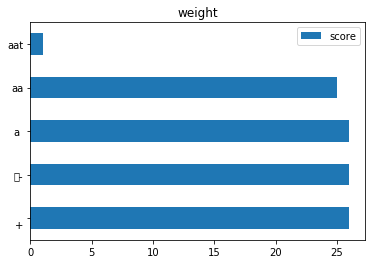

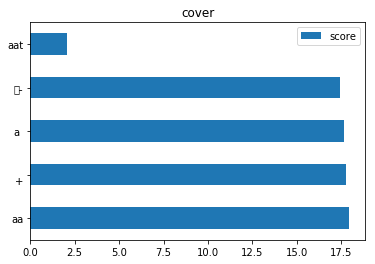

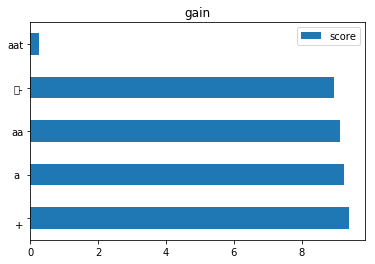

In [303]:
xgbmodel = FileClassifier(Dataset, ngram_range, max_features, param, num_round)

In [163]:
tdat = dataloader('/Users/bf/Desktop/BNL2020/BioClassifierFiles/GCA_902387845.1_UHGG_MGYG-HGUT-02512_genomic.fna.gz', 1000)
tdat2 = dataloader('/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna/GCA_000894255.1_ViralProj81175_genomic.fna.gz',1000)

In [180]:
datat = {'FastDat': tdat + tdat2,
         'Type': np.repeat(0,2)
    }
dft = pd.DataFrame(datat, columns = ['FastDat', 'Type'])
dft = dft[df.columns]

In [186]:
dft

,FastDat,Type
0,>LR699007.1 Morganella morganii isolate MGYG-H...,0
1,>LR699007.1 Morganella morganii isolate MGYG-H...,0


In [226]:
X = df.iloc[:,0].values
y = df.iloc[:,1].values

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [242]:
char_vectorizer = TfidfVectorizer(analyzer = 'char',
    ngram_range = ngram_range, max_features = max_features)
char_vectorizer.fit(X)
tc = char_vectorizer.transform(X_train)

In [243]:
ttest = xgb.DMatrix(tc, y_train)

In [244]:
bpred = np.asarray([np.argmax(line) for line in xgbmodel.predict(ttest)])

In [245]:
np.asarray(y_train).reshape(1,-1).squeeze()

array([3, 0, 1, 3, 0, 0, 0, 2, 1, 2, 0, 3, 3, 2, 1, 3, 1, 3, 0, 1, 1, 1,
       1, 1, 1, 0, 3, 2, 3, 1, 0, 1, 1, 3, 1, 0, 2, 2, 0, 0, 3, 1, 3, 2,
       0, 1, 0, 2, 1, 0, 0, 3, 2, 2, 3, 1, 0, 0, 3, 3, 3, 2, 0, 0, 2, 0,
       2, 2, 2, 0, 2, 3, 2, 3, 2, 2, 1, 1, 2, 2])

In [246]:
precision_score(y_train, bpred, average='macro')

1.0